In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
df = pd.read_csv('data/SPX_25yr_data.csv')
changes_df = pd.DataFrame(df['Date'][1:])
pct_change = [100 * (df['Adj Close'][i+1] / df['Adj Close'][i] - 1) for i in range(df['Adj Close'].size - 1)]
changes_df.insert(1, column='Pct Change', value=pct_change)

In [4]:
from datetime import datetime, timedelta
import ephem

In [5]:
moon = ephem.Moon()
moon_illumination = []
for day in changes_df['Date']:
    moon.compute(datetime.fromisoformat(day))
    moon_illumination.append(moon.phase)

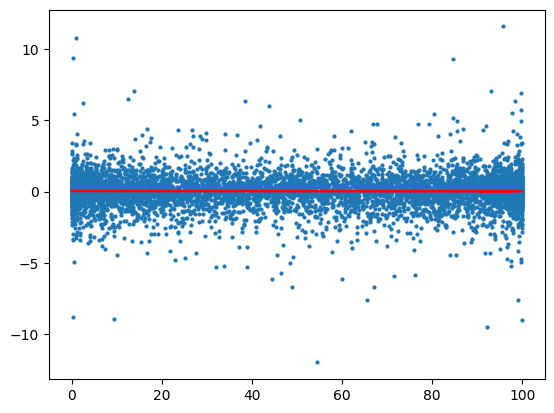

In [6]:
moon_brightness_df = changes_df.copy()
moon_brightness_df.insert(2, column='Moon Brightness %', value=moon_illumination)

x = np.array(moon_brightness_df['Moon Brightness %'])
y = np.array(moon_brightness_df['Pct Change'])
linreg_result = stats.linregress(x, y)
m, c, r, p, m_stderr = linreg_result
plt.plot(x, m*x + c, color='r')
plt.scatter(x, y, s=4)

In [7]:
binary = ['not', '']
print(f'Relationship {binary[float(p)<=0.05]} statistically significant at the p=0.05 level (p={p})')

Relationship not statistically significant at the p=0.05 level (p=0.7951415452808424)


In [8]:
moon_illumination_2 = []
for day in changes_df['Date']:
    days_from_full = datetime.fromisoformat(day) - ephem.previous_full_moon(day).datetime()
    moon_illumination_2.append(days_from_full.days)

In [9]:
changes_df_2 = changes_df.copy()
changes_df_2.insert(2, column='Days since full moon', value=moon_illumination_2)

In [10]:
averages = []
for i in range(30):
    moon_phase_info = changes_df_2[changes_df_2['Days since full moon'] == i]['Pct Change']
    avg = sum(moon_phase_info) / moon_phase_info.size
    averages.append(avg)

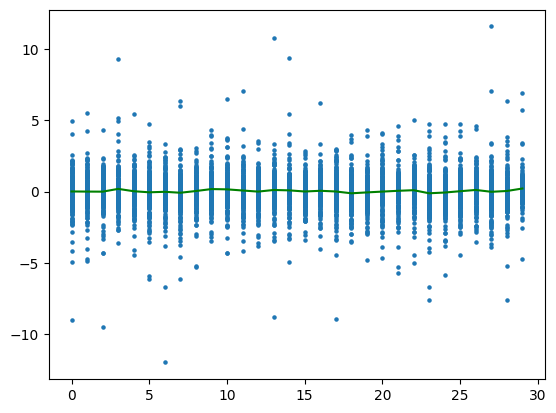

In [11]:
plt.scatter(x=moon_illumination_2, y=changes_df['Pct Change'], s=5)
plt.plot(averages, c='g')

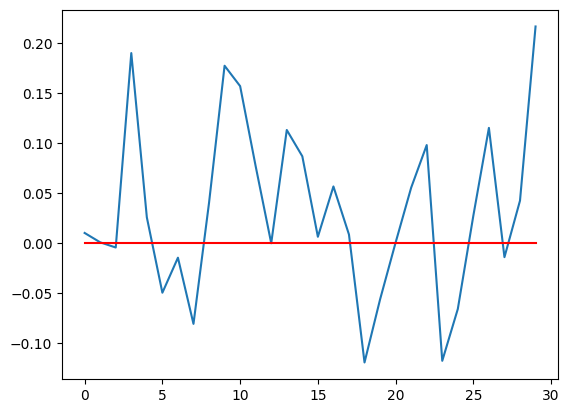

In [12]:
plt.plot(averages)
plt.plot([0 for i in range(30)], c='r')

In [13]:
def moon_strat(start_date, end_date, capital, buy_phase, sell_phase):
    '''Invest all capital into stock when the moon is in buy_phase and sell all when moon is in sell_phase.
    Cap daily pnl at +- 3.5% to smooth variance. (??? todo)\n
    If buy_phase and sell_phase are the same, then no actual trading takes place and this returns the natural stock performance.\n
    Phases: full moon = 0, waning gibbous = 1, ... , waxing gibbous = 7.'''

    phases = [{*range(int(i*3.75 + 0.5) - 2, int(i*3.75 + 4.25) - 2)} for i in range(8)]
    phases[0] = {28, 29, 0, 1}
    
    # get start idx
    while changes_df_2[changes_df_2['Date'].isin([start_date])].empty:
        new_start_date_raw = datetime.strptime(start_date, r'%Y-%m-%d') + timedelta(days=1)
        start_date = new_start_date_raw.strftime(r'%Y-%m-%d')
    time = changes_df_2[changes_df_2['Date'].isin([start_date])].index[0]

    # get end idx
    while changes_df_2[changes_df_2['Date'].isin([end_date])].empty:
        new_end_date_raw = datetime.strptime(end_date, r'%Y-%m-%d') - timedelta(days=1)
        end_date = new_end_date_raw.strftime(r'%Y-%m-%d')
    end_idx = changes_df_2[changes_df_2['Date'].isin([end_date])].index[0]
    
    if buy_phase == sell_phase:
        return capital * df['Close'][end_idx] / df['Close'][time]
    
    # uncomment this section if you want to force sell at the end
    # while changes_df_2['Days since full moon'][end_idx] not in phases[sell_phase]:
    #     end_idx -= 1
    # while changes_df_2['Days since full moon'][end_idx] in phases[sell_phase]:
    #     end_idx += 1
    
    while changes_df_2['Days since full moon'][time] not in phases[buy_phase]:
        time += 1
    buy = True
    sell = False
    inventory = 0.0
    stock_prices = []
    while time < end_idx:
        days_since_full = changes_df_2['Days since full moon'][time]
        if buy:
            # spend equal amount of money per day in buy period
            if days_since_full in phases[buy_phase]:
                stock_prices.append(df['Close'][time])
                time += 1
            else:
                for price in stock_prices:
                    money_spent = capital / len(stock_prices)
                    inventory += money_spent / price
                capital = 0
                stock_prices = []
                buy = False
        elif sell:
            # sell equal # of stocks per day
            if days_since_full in phases[sell_phase]:
                stock_prices.append(df['Close'][time])
                time += 1
            else:
                for price in stock_prices:
                    stocks_sold = inventory / len(stock_prices)
                    capital += stocks_sold * price
                inventory = 0
                stock_prices = []
                sell = False
        else:
            if days_since_full in phases[buy_phase]: buy = True
            elif days_since_full in phases[sell_phase]: sell = True
            else:
                time += 1
    return capital + inventory * df['Close'][end_idx]

In [14]:
# moon_strat(start_date='2010-01-01', end_date='2011-01-01', capital=1000, buy_phase=0, sell_phase=4)
year = 2003
start_date = str(year) + '-01-01'
end_date = str(year+5) + '-01-01'

for sell_phase in range(8):
    toPrint = [' '*(5 - len((a := str(round(moon_strat(start_date, end_date, 1000, buy_phase, sell_phase)))))) + a for buy_phase in range(8)]
    print(' '.join(toPrint))

 1615  1541  1517  1461  1371  1070  1146  1125
 1060  1615  1653  1578  1445  1143  1246  1220
 1075  1014  1615  1656  1463  1156  1260  1225
 1117  1063  1049  1615  1533  1212  1321  1276
 1181  1122  1107  1057  1615  1279  1394  1349
 1491  1399  1380  1317  1267  1615  1738  1680
 1384  1275  1258  1201  1162   918  1615  1540
 1418  1310  1302  1251  1201   950  1030  1615


In [15]:
phase_mappings = {0: 'Full Moon',
                  1: 'Waning Gibbous',
                  2: 'Third Quarter',
                  3: 'Waning Crescent',
                  4: 'New Moon',
                  5: 'Waxing Crescent',
                  6: 'First Quarter',
                  7: 'Waxing Gibbous'}

Let's draw some graphs now! I'm going to draw two - the first as a sample just to see what to expect, and the second as the performance of these moon strats over the last 25 years.

In [ ]:
def draw_graphs(start_year, end_year, month_day):
    stock_baseline = moon_strat(str(start_year)+'-'+month_day, str(end_year)+'-'+month_day, 1000, 0, 0)

    moon_phase_buy = np.arange(8)  # Replace with your 8 x1 values
    moon_phase_sell = np.arange(8)  # Replace with your 8 x2 values

    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))

    # Loop over x1 and x2 values
    for i, phase_sell in enumerate(moon_phase_buy):
        for j, phase_buy in enumerate(moon_phase_sell):
            ax = axes[i, j]
            
            annual_portfolio = [1000]
            until = start_year
            while until != end_year:
                start_date = str(until) + '-' + month_day
                end_date = str(until+1) + '-' + month_day
                old_value = annual_portfolio[-1]
                new_value = moon_strat(start_date, end_date, old_value, phase_buy, phase_sell)
                annual_portfolio.append(new_value)
                until += 1
            
            # Draw line for no change and
            # color strategies based on whether they beat the stock baseline
            ax.plot([0, len(annual_portfolio)], [1000, 1000], linewidth = 1, c = 'k')
            if i == j: color = 'b'
            elif annual_portfolio[-1] >= stock_baseline: color = 'g'
            else: color = 'r'
            ax.plot(annual_portfolio, linewidth = 2.5, c = color)
            ax.set_xlim([0, len(annual_portfolio)])
            ax.set_ylim([0, 6000])
            
            # Only set labels on the edges of the grid
            if j == 0:
                ax.set_ylabel(f'Sell, {phase_mappings[phase_sell]}', rotation=90, fontsize=10, labelpad=10)
            if i == 0:
                ax.set_title(f'Buy, {phase_mappings[phase_buy]}', fontsize=10, pad=10)

            # Hide ticks to clean up the plot
            ax.set_xticks([])
            ax.set_yticks([])

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Adjust the space between the plots for better label visibility
    plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05)

    plt.suptitle(f"Trading SPX based on moon phase from {str(start_year)+'-'+month_day} to {str(end_year)+'-'+month_day}", fontsize=18, y=1)

    # Show the plot
    plt.show()

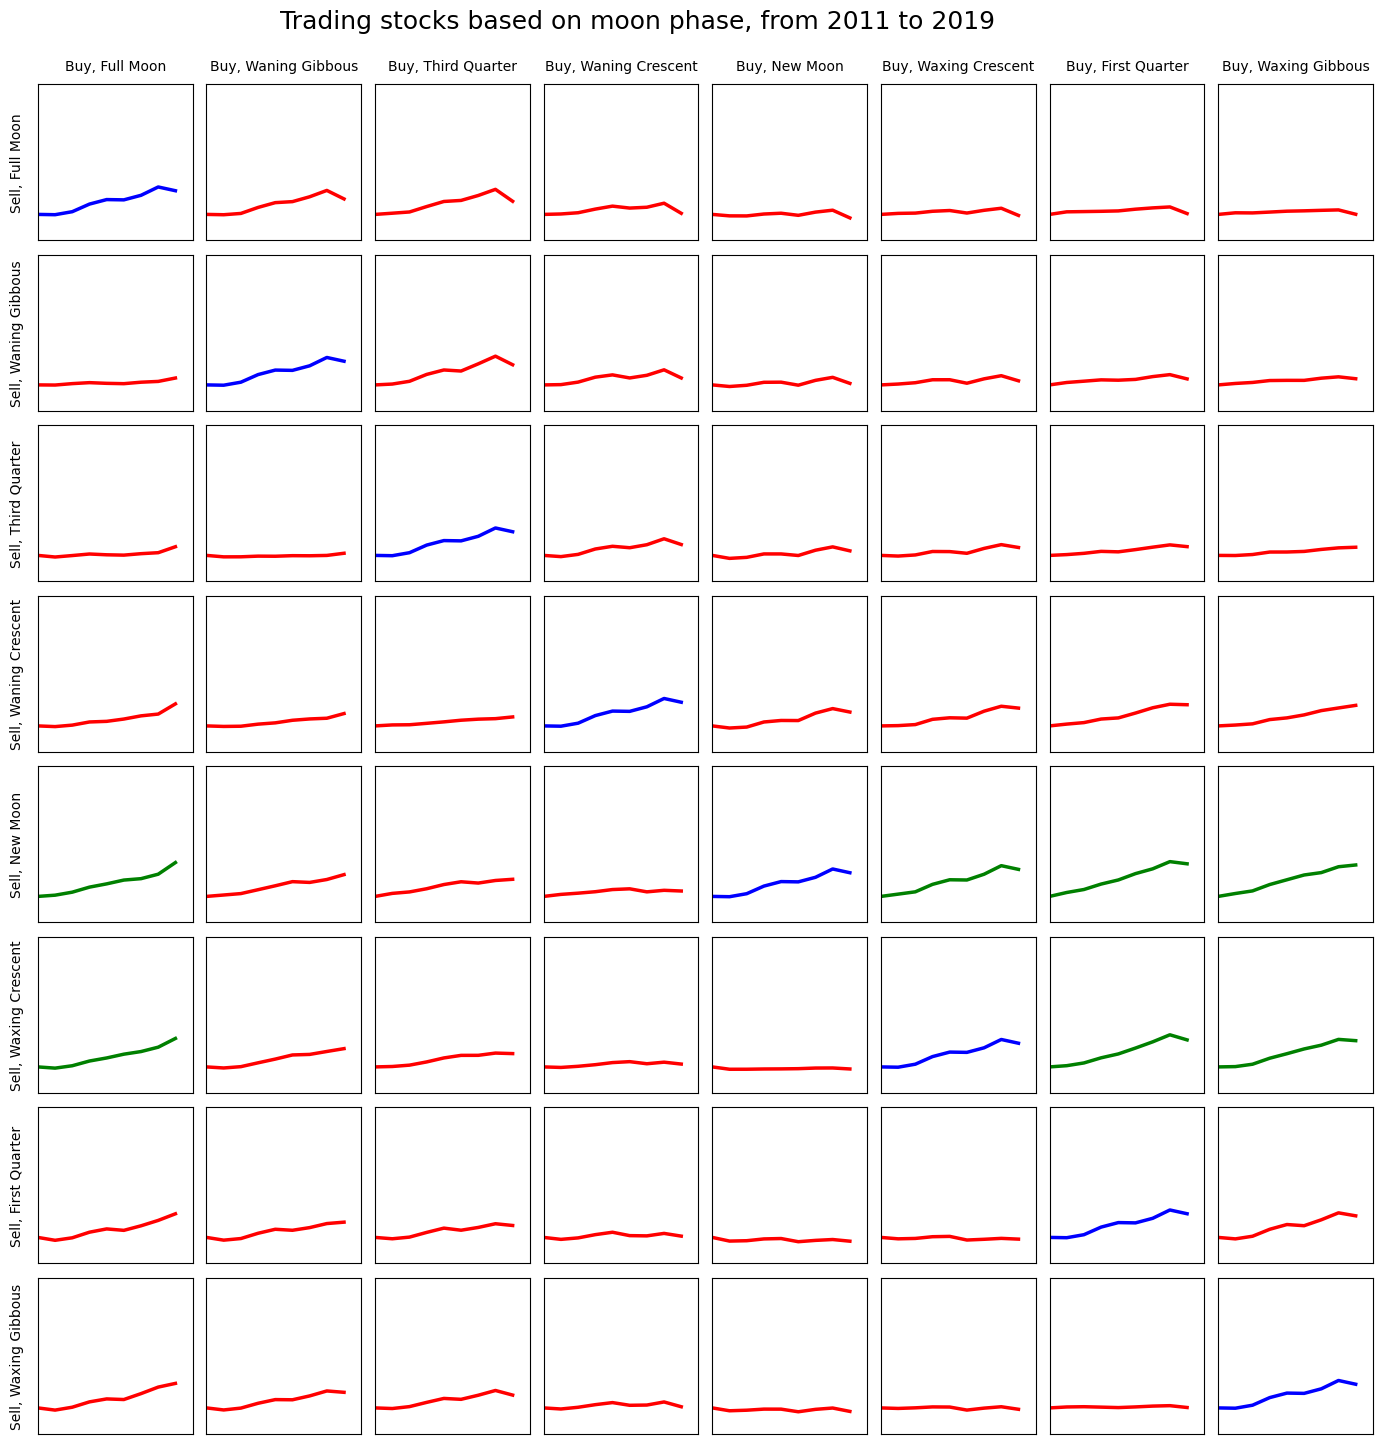

In [16]:
draw_graphs(start_year=2011, end_year=2019, month_day='01-01')

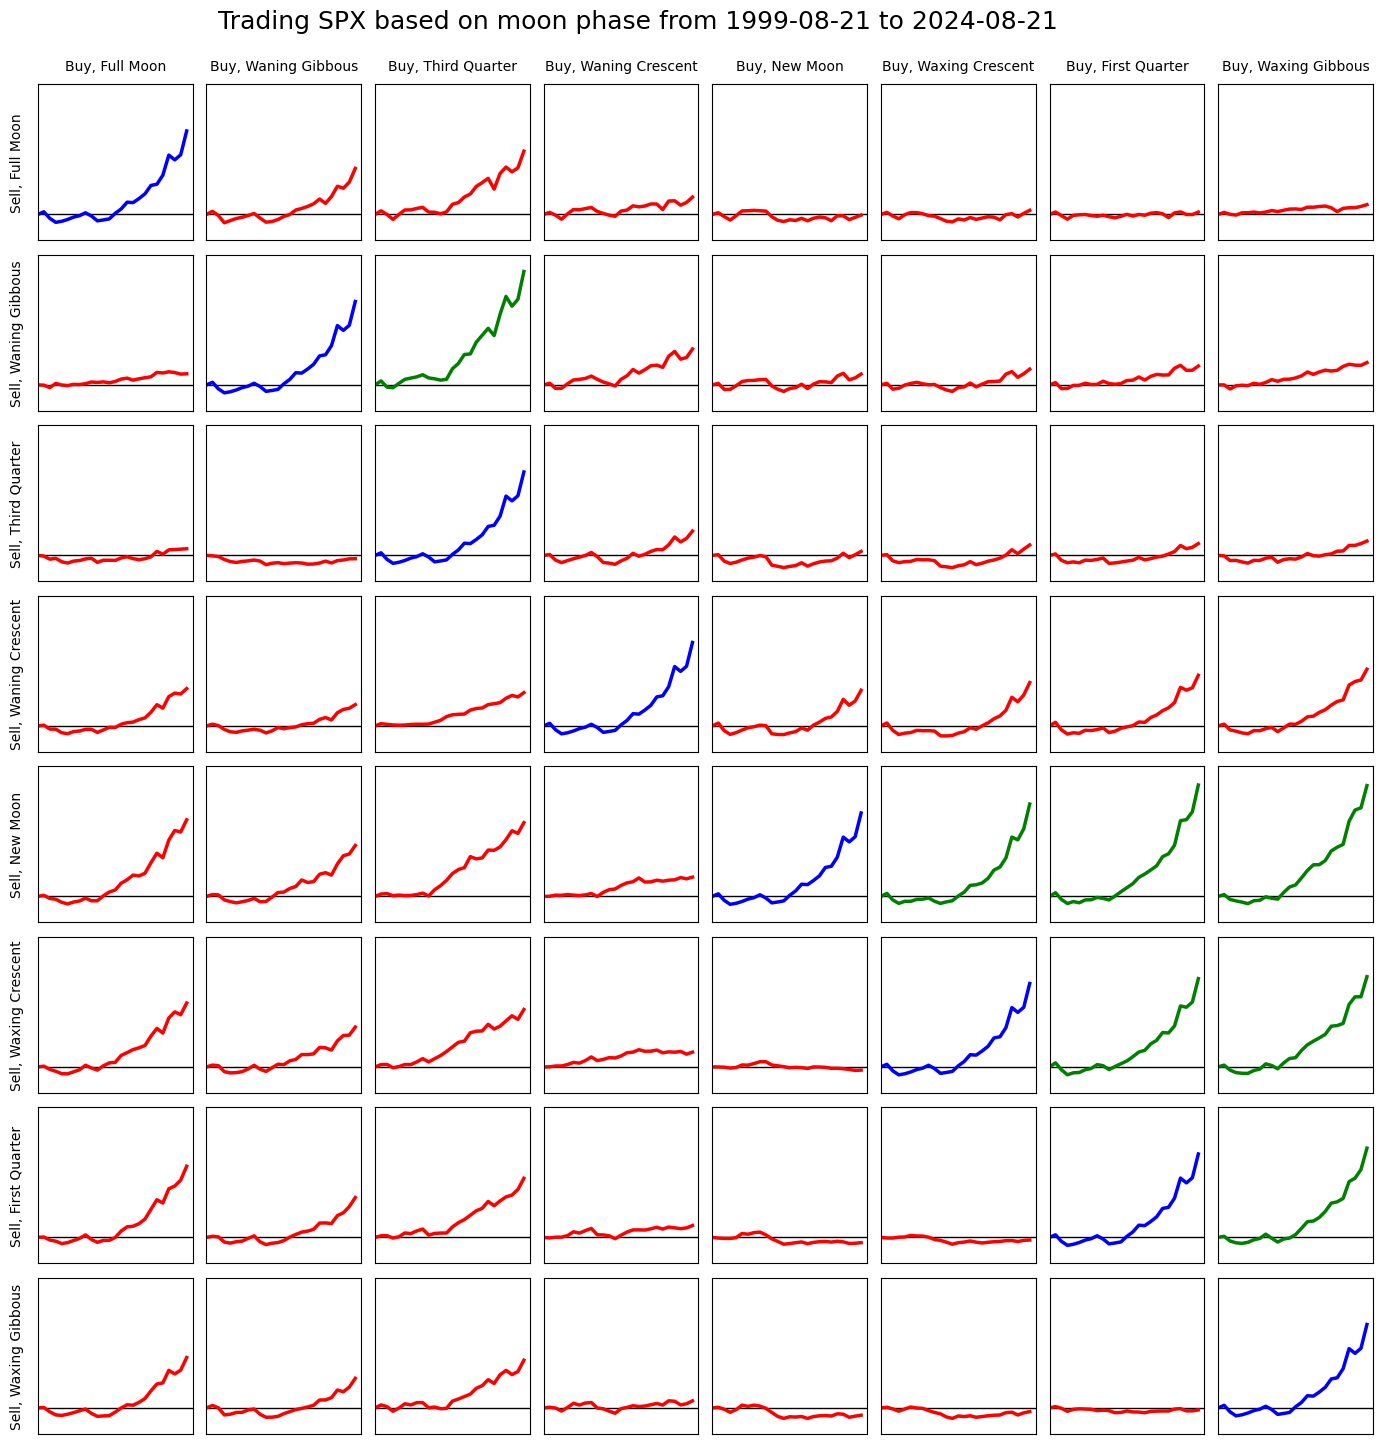

In [18]:
draw_graphs(start_year=1999, end_year=2024, month_day='08-21')

We now would like to test whether these results really are significant or if they can be caused by random chance. In particular, there exists a triangle of green in the bottom graph, which appears to be mostly intact in the top graph (though these two are very highly correlated). I will focus on the <b>inverse</b> of the profitable trades - out of 560 randomly generated strategies (with total holding periods corresponding to the total holding periods in the strats pictured above), what percent of them <i>lose</i> money? (If a trade loses money, then its inverse trade must beat the baseline SP500 performance, as we removed parts from the baseline that lose money!)

Now let's try an ecological regression approach. Based on the results of the past year, we pick a moon phase to buy and sell on for each year (or each day). Let's see how that performs!
Alternatively, we can also try basing the results of moon-cycle-based trades off a model that takes in results from the last few years but has their weighting exponentially decay as they age, e.g. if a result from 5 months ago has importance x < 1, then a result from 10 months ago has importance x^2.